In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672550900000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [5]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 14:59:59  1194.55  1194.81  1195.23  1193.81   4102.0957
1     2023-01-01 15:59:59  1194.81  1195.06  1195.75  1193.04   5826.7698
2     2023-01-01 16:59:59  1195.07  1194.28  1195.90  1194.17   3124.6022
3     2023-01-01 17:59:59  1194.27  1196.48  1196.55  1193.98   2763.9478
4     2023-01-01 18:59:59  1196.47  1197.14  1197.19  1195.59   2006.5809
...                   ...      ...      ...      ...      ...         ...
2042  2023-03-27 17:59:59  1756.20  1763.38  1765.02  1754.49  15640.8771
2043  2023-03-27 18:59:59  1763.37  1764.96  1766.83  1760.14   9224.8710
2044  2023-03-27 19:59:59  1764.96  1765.42  1770.20  1762.71  10745.8941
2045  2023-03-27 20:59:59  1765.42  1756.10  1769.33  1752.49  16119.3887
2046  2023-03-27 21:59:59  1756.10  1752.74  1759.00  1750.63  10976.5839

[2047 rows x 6 columns]


In [6]:
df = raw_df.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slow_k'] < df['slow_d']
    return series.diff() & series

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low      Volume  \
0     2023-01-01 14:59:59  1194.55  1194.81  1195.23  1193.81   4102.0957   
1     2023-01-01 15:59:59  1194.81  1195.06  1195.75  1193.04   5826.7698   
2     2023-01-01 16:59:59  1195.07  1194.28  1195.90  1194.17   3124.6022   
3     2023-01-01 17:59:59  1194.27  1196.48  1196.55  1193.98   2763.9478   
4     2023-01-01 18:59:59  1196.47  1197.14  1197.19  1195.59   2006.5809   
...                   ...      ...      ...      ...      ...         ...   
2042  2023-03-27 17:59:59  1756.20  1763.38  1765.02  1754.49  15640.8771   
2043  2023-03-27 18:59:59  1763.37  1764.96  1766.83  1760.14   9224.8710   
2044  2023-03-27 19:59:59  1764.96  1765.42  1770.20  1762.71  10745.8941   
2045  2023-03-27 20:59:59  1765.42  1756.10  1769.33  1752.49  16119.3887   
2046  2023-03-27 21:59:59  1756.10  1752.74  1759.00  1750.63  10976.5839   

            ema_8       ema_18       ema_38        atr        rsi     slow_

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] <= df['ema_38']


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_entry
0,2023-01-01 14:59:59,1194.55,1194.81,1195.23,1193.81,4102.0957,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
1,2023-01-01 15:59:59,1194.81,1195.06,1195.75,1193.04,5826.7698,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 16:59:59,1195.07,1194.28,1195.90,1194.17,3124.6022,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 17:59:59,1194.27,1196.48,1196.55,1193.98,2763.9478,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 18:59:59,1196.47,1197.14,1197.19,1195.59,2006.5809,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,2023-03-27 17:59:59,1756.20,1763.38,1765.02,1754.49,15640.8771,1759.573896,1761.762706,1761.557637,11.470540,51.057844,45.273364,28.790735,False,False,False,True,False,False,False
2043,2023-03-27 18:59:59,1763.37,1764.96,1766.83,1760.14,9224.8710,1760.770808,1762.099263,1761.732117,11.129072,52.054982,49.528683,40.245983,False,False,False,True,False,False,False
2044,2023-03-27 19:59:59,1764.96,1765.42,1770.20,1762.71,10745.8941,1761.803962,1762.448814,1761.921239,10.869139,52.359305,50.767573,48.523207,False,False,False,True,False,False,False
2045,2023-03-27 20:59:59,1765.42,1756.10,1769.33,1752.49,16119.3887,1760.536415,1761.780518,1761.622714,11.295629,45.989923,25.666577,41.987611,True,True,True,True,False,False,False


In [11]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + 3 * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and entry_df.at[index, 'Close'] > stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (entry_df.at[index, 'Low'] <= close_val.shift(1).at[index] - 4 * atr_val.shift(1).at[index]) and in_position == True:
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan

entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


               Close_Time     Open    Close     High      Low      Volume  \
422   2023-01-19 04:59:59  1541.96  1521.38  1544.78  1516.55  30763.2242   
423   2023-01-19 05:59:59  1521.38  1528.46  1532.46  1519.62  13064.2538   
425   2023-01-19 07:59:59  1531.39  1511.43  1533.28  1507.90  21837.7252   
426   2023-01-19 08:59:59  1511.44  1516.26  1523.25  1509.15  18982.5522   
437   2023-01-19 19:59:59  1525.27  1519.61  1525.37  1516.17  12086.7352   
...                   ...      ...      ...      ...      ...         ...   
1999  2023-03-25 22:59:59  1754.42  1748.32  1757.39  1747.79  14177.6815   
2000  2023-03-25 23:59:59  1748.33  1754.93  1763.23  1744.64  20406.0843   
2002  2023-03-26 01:59:59  1752.85  1744.32  1754.43  1740.74  17742.4911   
2003  2023-03-26 02:59:59  1744.31  1738.93  1746.45  1737.50  13881.5668   
2022  2023-03-26 21:59:59  1775.56  1796.47  1801.00  1773.16  38926.7285   

            ema_8       ema_18       ema_38        atr  ...  kd_cross     c

In [12]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Buy':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] - 4 * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Short', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Buy').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low        ema_8  \
0    2023-01-19 05:59:59  1521.38  1528.46  1532.46  1519.62  1542.883810   
1    2023-01-19 08:59:59  1511.44  1516.26  1523.25  1509.15  1529.984481   
2    2023-01-19 20:59:59  1519.60  1519.19  1523.11  1513.33  1524.119909   
3    2023-01-20 04:59:59  1551.95  1557.44  1564.43  1551.94  1540.823937   
4    2023-01-24 04:59:59  1619.89  1634.80  1635.26  1618.65  1626.530740   
..                   ...      ...      ...      ...      ...          ...   
115  2023-03-25 17:59:59  1743.38  1748.17  1750.38  1739.98  1748.877202   
116  2023-03-25 20:59:59  1745.24  1745.50  1746.48  1738.78  1747.307929   
117  2023-03-25 23:59:59  1748.33  1754.93  1763.23  1744.64  1750.132729   
118  2023-03-26 02:59:59  1744.31  1738.93  1746.45  1737.50  1747.002505   
119  2023-03-26 21:59:59  1775.56  1796.47  1801.00  1773.16  1774.293104   

          ema_18       ema_38        atr  kd_cross position  entry_p  \
0  

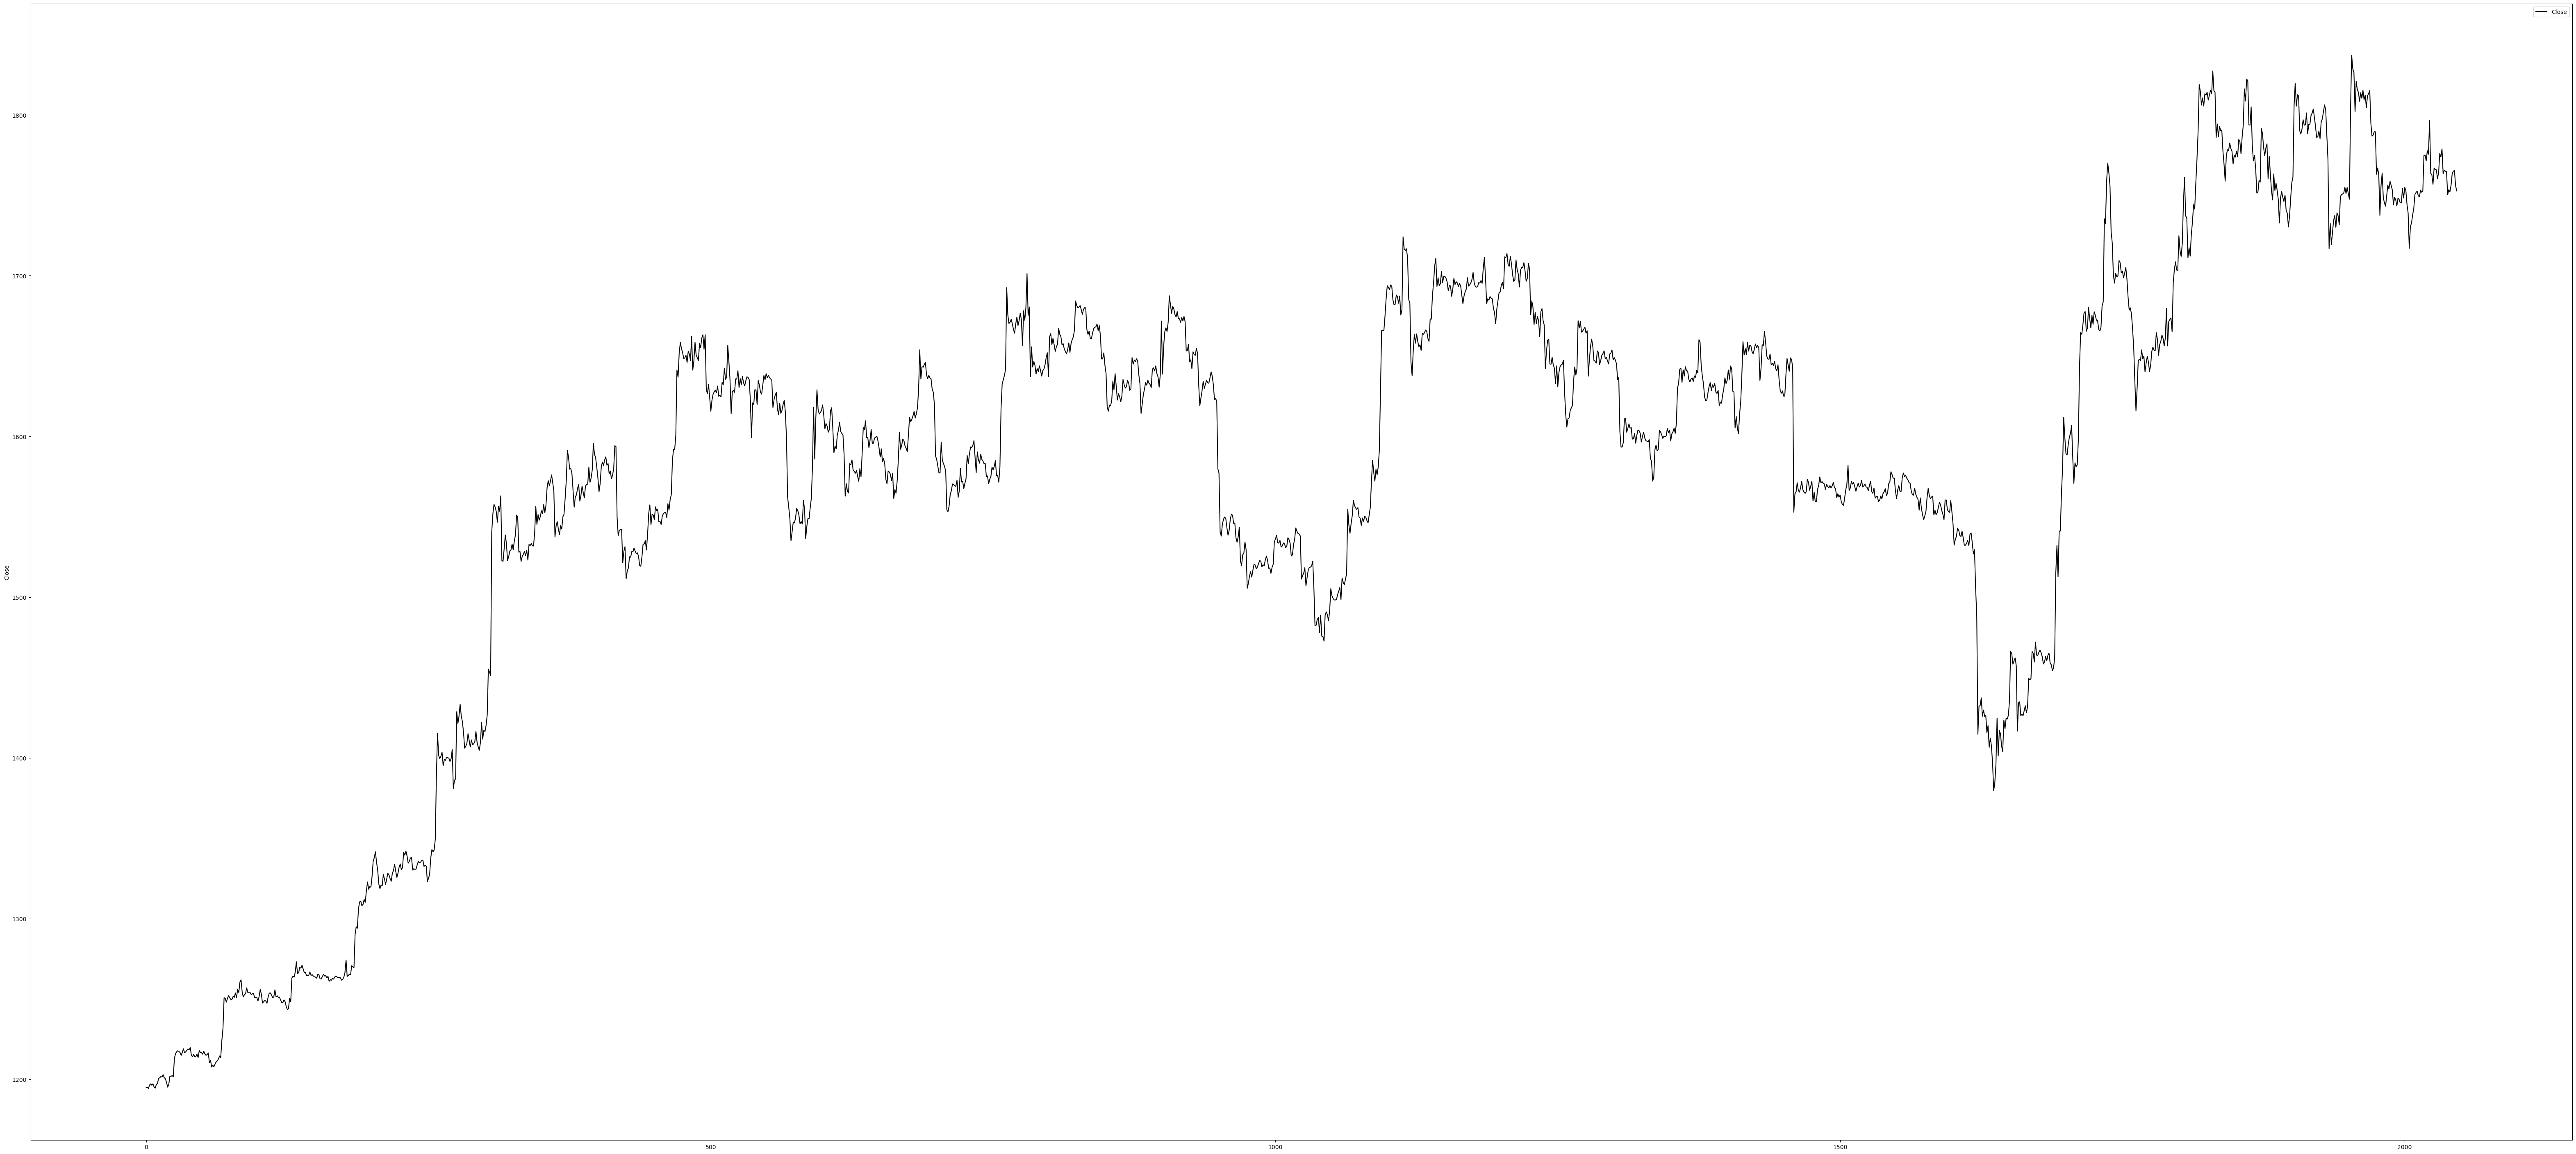

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Buy':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()